# Workshop Beeldherkenning

# Auto's herkennen met beeldherkenning

In deze workshop wordt uitgelegd hoe we objecten, zoals auto's en verkeersborden op afbeeldingen kunnen herkennen door middel van een neuraal netwerk te trainen in Tensorflow met behulp van een beeldherkenningsalgoritme dat **YOLO (You Only Look Once)** wordt genoemd.

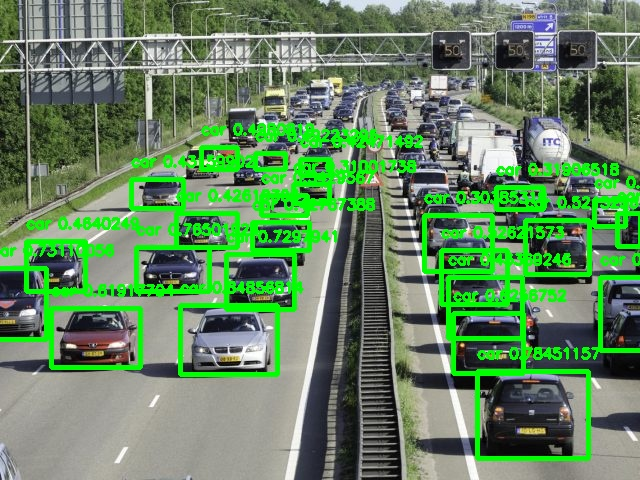

# Wat zijn neurale netwerken?

Neurale Netwerken (NN's) zijn computerprogramma's die patronen kunnen herkennen. Dit mechanisme is geïnspireerd op hoe hersenen zijn ontworpen: Neuronen (Nodes) die aan elkaar verbonden zijn en leren hoe ze moeten reageren op inkomende signalen. Die nodes zijn georganiseerd in lagen.

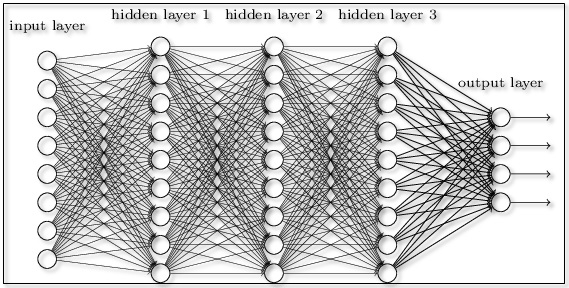

# Aan de slag! 

We gebruiken voor dit project Python 3.5. Voordat we aan de slag kunnen met de code, moeten we een aantal Python packages installeren die nodig zijn om een neuraal netwerk te gaan trainen en met afbeeldingen te werken: bijv. keras, matplotlib, tensorflow. Dit doen we door middel van "pip install" commando in de terminal.

In [ ]:
pip install keras tensorflow imgaug numpy os cv2 matplotlib pickle tqdm 

Vervolgens moeten we de geïnstalleerde packages nog importeren in de code voordat we ze kunnen gebruiken. Dit doen we door middel van "import".

In [7]:
# Algemene packages (deze heb je waarschijnlijk al):
import os, cv2
import numpy as np
from tqdm import tqdm
import pickle

# Packages nodig om neuraal netwerk te trainen:
import keras
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import keras.backend as K
import tensorflow as tf

# Packages nodig om afbeeldingen te verwerken:
import matplotlib.pyplot as plt
import imgaug as ia
from imgaug import augmenters as iaa

# Functies van andere scriptjes, zorg dat preprocessing.py en utils.py in dezelfde map staan als dit script. 
# Deze twee functies hoef je niet te installeren via pip install.
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

%matplotlib inline

Using TensorFlow backend.
/Users/laura/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


We geven een aantal parameters mee zodat er een netwerk getraind kan gaan worden. Zie de tabel in het meegeleverde document voor uitleg van de parameters.  Dit zijn o.a. de labels waarop netwerk moet gaan trainen, grootte van afbeelding etc. Zie referenties voor de artikels met uitgebreidere uitleg. 

In [8]:
LABELS = ['person', 'bicycle', 'car', 'motorcycle', 'bus', 'train', 'truck', 'boat', 'traffic light', 'stop sign']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.3
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 2
TRUE_BOX_BUFFER  = 50

# Het voorbereiden van de train- en validatieset 
Daarnaast hebben we een dataset met afbeeldingen en annotaties (xml-bestanden) nodig. Deze dataset is opgesplitst in een  train- en validatieset voor zowel de afbeeldingen als de annotaties. We moeten definieren in welke map de afbeeldingen en annotaties staan. 

In [9]:
wt_path = 'yolo.weights'   
train_annot_folder = 'COCO_folder/eigen_data/annotations/train_snelweg/'
train_image_folder = 'COCO_folder/eigen_data/images/train_snelweg/'
valid_image_folder = 'COCO_folder/eigen_data/images/val/'
valid_annot_folder = 'COCO_folder/eigen_data/annotations/val/'

# Het netwerk maken

Om het neuraal netwerk te kunnen gaan trainen, moeten we het netwerk laag voor laag gaan beschrijven, zodat het script snapt wat er gedaan moet worden. Het YOLO algoritme is een convolutional neural network (CNN) bestaande uit 24 convolutional en maxpool layers, gevolgd door twee fully connected layers aan het einde van het netwerk. 

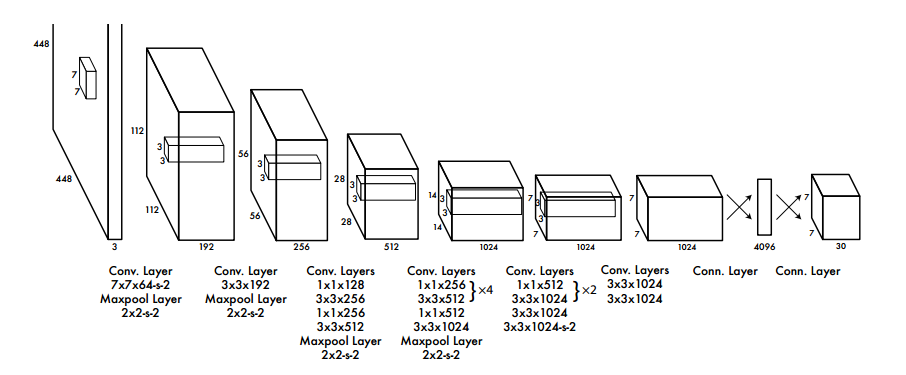

In [10]:
# the function to implement the orgnization layer 
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [11]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)

W0822 14:33:58.515527 140736183309184 deprecation_wrapper.py:119] From /Users/laura/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 14:33:58.529813 140736183309184 deprecation_wrapper.py:119] From /Users/laura/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 14:33:58.532883 140736183309184 deprecation_wrapper.py:119] From /Users/laura/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0822 14:33:58.547791 140736183309184 deprecation_wrapper.py:119] From /Users/laura/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_se

Hierbij een samenvatting van het model met de ouput shapes:

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

# Het inladen van de pretrained weights

Het trainen van een model kost veel tijd en rekenkracht, vandaar dat we al werken met pretrained weights (voorgetrainde gewichten). Deze kunnen gedownload worden van deze link: https://pjreddie.com/media/files/yolo.weights en worden vervolgens ingeladen. 

In [13]:
weight_reader = WeightReader(wt_path)

In [14]:
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

De gewichten van de laatste laag worden gerandomiseerd, anders hebben alle gewichten dezelfde waarden (4). 

In [15]:
layer   = model.layers[-4] # the last convolutional layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

# Definieren van een aantal functies nodig voor de training

Het algoritme gebruikt een sum-squared error functie tussen de predicted boxes en de ground truth om de loss uit te rekenen voor iedere epoch, de loss moet aan het einde van een run zo laag mogelijk zijn (~0.01 – 0.10). Om te kijken of je training goed is gegaan, kun je dus naar de waarde van je loss kijken. De totale loss functie bestaat uit drie delen: **classification loss**, **localization loss** en **confidence loss**. In het document dat is meegegeven staat meer uitleg over de verschillende delen van de loss functie.


### Totale loss =
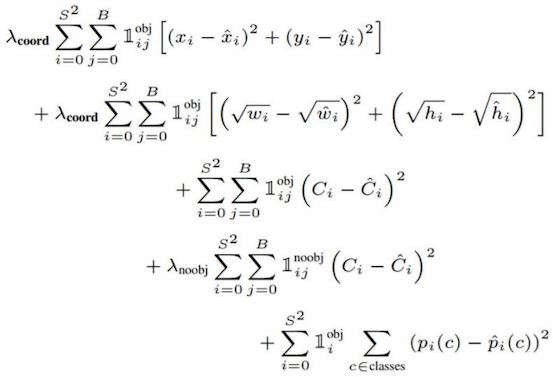

In [16]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

In [17]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [18]:
def normalize(image):
    return image / 255.

# Het inlezen van de dataset
Vervolgens lezen we hier de datasets in. Als je hier een foutmelding krijgt, dan zijn de paden in het begin van de code niet goed opgegeven. Controleer deze!

In [19]:
train_imgs, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder, labels=LABELS)
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)
valid_imgs, seen_valid_labels = parse_annotation(valid_annot_folder, valid_image_folder, labels=LABELS)
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

# Een paar callbacks instellen 

Een callback is een set met functies die in de trainingsperiode worden toegepast. In deze code zijn er drie type callbacks: **early_stop**, **checkpoint** en **Tensorboard**.

- **early_stop** kan worden ingesteld om de training eerder de stoppen, als de val_loss niet beter wordt.
- **checkpoint** slaat telkens de laatste beste versie op van het model. 
- **Tensorboard** kan gebruikt worden om bepaalde statistieken en grafieken over hoe de loss functie over de training zich evalueert, te bekijken. 


In [20]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_coco_car.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

# Starten van de training 

Vervolgens kan het model getraind worden. Je kunt het aantal epochs zelf instellen, om een goed model te krijgen heb je >50 epochs nodig. Let wel op dat het trainen op een laptop of gewone computer lang duurt, dus probeer eerst het aantal epochs op 3 te zetten om te kijken wat er gebeurt. Het trainen van het model gebeurt in het Datalab op de DGX (ook wel “de supercomputer” genoemd), deze bevat meerdere GPUs en dus gaat het trainen sneller.

Controleer of er aan het einde van de training een model is opgeslagen (een .h5 bestand). 


In [21]:
tb_counter  = len([log for log in os.listdir(os.path.expanduser('~/Documents/workshop/logs/')) if 'coco_' in log]) + 1
tensorboard = TensorBoard(log_dir=os.path.expanduser('~/Documents/workshop/logs/') + 'coco_' + '_' + str(tb_counter), 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)

optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 10, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [early_stop, checkpoint, tensorboard], 
                    max_queue_size   = 3)

W0822 14:34:21.117022 140736183309184 deprecation_wrapper.py:119] From /Users/laura/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0822 14:34:21.124566 140736183309184 deprecation.py:323] From <ipython-input-16-1c1e9c0c2ea6>:4: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0822 14:34:21.267759 140736183309184 deprecation.py:323] From <ipython-input-16-1c1e9c0c2ea6>:145: Print (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2018-08-20.
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. T

Epoch 1/10


KeyboardInterrupt: 

# Afbeelding detecteren

Nadat het model is gegenereerd, kan het model toegepast worden op een willekeurige afbeelding van de validatieset en kan er een voorspelling gedaan worden van de objecten op de afbeelding. Eerst wordt het gegenereerde model ingeladen:

In [22]:
# Netwerk getraind met COCO data:
#model.load_weights("weights_coco.h5")

# Netwerk getraind met autobeelden:
model.load_weights("weights_coco_car_6.h5")

Vervolgens laad je een willekeurige afbeelding in (die niet aanwezig was in de trainset) en wordt er een gedetecteerde afbeelding gegenereerd op basis van de voorspelling die gedaan is.

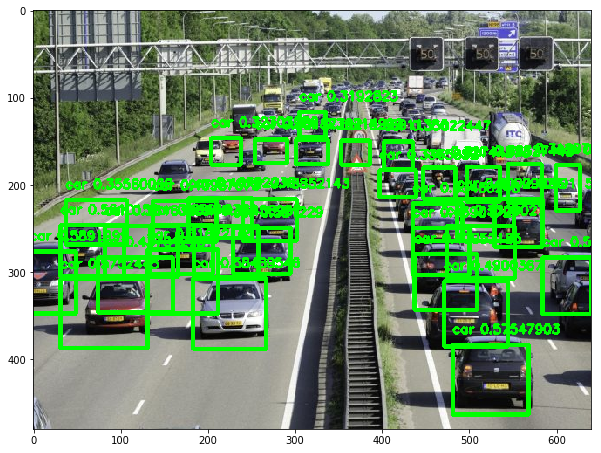

In [23]:
image = cv2.imread('snelweg.jpg')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)


cv2.imwrite('_detected.jpg', image)

plt.imshow(image[:,:,::-1])
plt.show()


# Model verbeteren
En is je gegenereerde model in staat om de auto’s op de juiste positie te detecteren (zoals in figuur 1)? 

- Zo, nee. Probeer dan een nieuw model te generen en kijken of er een beter model uitkomt. 

- Bedenk welke parameters je kunt aanpassen om misschien een beter model te krijgen. 

# Referenties 

(1) Algemene uitleg over YOLO algoritme:
https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006

(2) Uitleg over nms- en iou-threshold:
https://towardsdatascience.com/you-only-look-once-yolo-implementing-yolo-in-less-than-30-lines-of-python-code-97fb9835bfd2

(3) Uitleg over anchor boxes:
https://medium.com/@andersasac/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9

(4) Waarom weights van de laatste laag randomiseren:
https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78

(5) Uitleg over loss function:
https://medium.com/@jonathan_hui/real-time-object-detection-with-yolo-yolov2-28b1b93e2088
